#### Imports

In [1]:
import os, sys
import numpy as np
import random
import math
import tqdm
import torch
import collections
from collections import namedtuple, deque
import statistics
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

c:\ProgramData\miniconda3\envs\python3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Replay

In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class Replay(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#### Neural Network

In [3]:
class CNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(27, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(256, 9)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

#### Environment

In [4]:
class TicTacToe:
    def __init__(self, config: dict):
        """
        Inicia a classe do game
        Arguments:
            Array config: Configurações de recompensas
        Returns:
            Void
        """

        # Configurações do game
        self.config  =  config

        # Quantidade de jogadas por partida
        self.played  =  0     

        # Matriz da partida
        self.game    =  []

        # Situação do game
        self.done   =  True

        # Total de ações
        self.spaceAction  =  9

        self.lastAction   =  -1

        self.loss = 0
        self.winn = 1

        # Represeta os jogadores na partida
        self.pX      =  1
        self.pO      =  2

    def newGame(self, player='X'):
        """
        Inicia uma nova partida
        Arguments:
            String player: Usuário que inicia a partida
        Returns:
            Void
        """
        self.lastAction = -1
        self.done    =  False
        self.player  =  player        
        self.game    =  np.zeros(9).astype(int)
        self.played  =  0
        return self.getObservable()

    def getObservable(self):
        """
        Retorna a matriz do game com a jogada anterior
        Returns:
            Array
        """
        state  = self.game
        #state  = np.append(state, self.lastAction)
        
        # Retorna o estado
        return state        

    def getActionSpace(self):
        return self.spaceAction

    def getAction(self, randomAction: bool = True) -> int:
        """
        Retorna uma ação
        Arguments:
            Bool randomAction: Se a ação será gerada de forma randômica
                               True  - Ação randômica
                               False - Ação baseada em movimentos válidos
        Returns:
            Void
        """

        # Verifica se a opção
        if randomAction:
            # Gera a ação
            return random.randrange( self.spaceAction )

        # Retorna uma ação baseada em movimentos válidos
        return random.choice( self.getOnlyValidAction() )

    def getOnlyValidAction(self) -> list:
        """
        Retorna somente os locais válidos para jogar
        Returns:
            Array
        """

        # Lista com os itens válidos
        valid = []

        # Contador da lista
        j = 0

        # Loop na matriz do jogo
        for i in self.game:
            
            # Verifica as posições validas
            if i == 0:

                # Coloca o item na lista
                valid.append(j)

            # Incrementa o contador
            j += 1

        # Retorna  a lista dos itens válidos
        return valid
    
    def checkWinner( self, player: str ) -> bool:
        """
        Verifica se a partida tem um vencedor
        Arguments:
            String player: Usuário que será verificado
        Returns:
            Boolean
        """

        # Obtem o valor do player repsentado na matriz
        p = self.pX if player == 'X' else self.pO

        # Seta a partida como terminada
        self.done  =  True

        # Verifica se houve um vencedor
        if self.game[0] == p and self.game[1] == p and self.game[2] == p:
            return True
        elif self.game[3] == p and self.game[4] == p and self.game[5] == p:
            return True
        elif self.game[6] == p and self.game[7] == p and self.game[8] == p:
            return True
        elif self.game[0] == p and self.game[3] == p and self.game[6] == p:
            return True
        elif self.game[1] == p and self.game[4] == p and self.game[7] == p:
            return True
        elif self.game[2] == p and self.game[5] == p and self.game[8] == p:
            return True
        elif self.game[0] == p and self.game[4] == p and self.game[8] == p:
            return True
        elif self.game[2] == p and self.game[4] == p and self.game[6] == p:
            return True

        # Não venceu, então o jogo continua  
        self.done  = False

        # Retorna o boolean, informando que o jogo nao terminou
        return False
    
    def checkPossibilityWon(self, p):
        """
        Verifica se a partida tem um vencedor
        Arguments:
            String player: Usuário que será verificado
        Returns:
            Boolean
        """

        odd =  0

        if (self.game[0] == 0 and self.game[1] == p and self.game[2] == p) or \
           (self.game[0] == p and self.game[1] == 0 and self.game[2] == p) or \
           (self.game[0] == p and self.game[1] == p and self.game[2] == 0): 
            odd += 1
         
        if (self.game[3] == 0 and self.game[4] == p and self.game[5] == p) or \
           (self.game[3] == p and self.game[4] == 0 and self.game[5] == p) or \
           (self.game[3] == p and self.game[4] == p and self.game[5] == 0): 
            odd += 1

        if (self.game[6] == 0 and self.game[7] == p and self.game[8] == p) or \
           (self.game[6] == p and self.game[7] == 0 and self.game[8] == p) or \
           (self.game[6] == p and self.game[7] == p and self.game[8] == 0): 
            odd += 1

        if (self.game[0] == 0 and self.game[3] == p and self.game[6] == p) or \
           (self.game[0] == p and self.game[3] == 0 and self.game[6] == p) or \
           (self.game[0] == p and self.game[3] == p and self.game[6] == 0): 
            odd += 1

        if (self.game[1] == 0 and self.game[4] == p and self.game[7] == p) or \
           (self.game[1] == p and self.game[4] == 0 and self.game[7] == p) or \
           (self.game[1] == p and self.game[4] == p and self.game[7] == 0): 
            odd += 1

        if (self.game[2] == 0 and self.game[5] == p and self.game[8] == p) or \
           (self.game[2] == p and self.game[5] == 0 and self.game[8] == p) or \
           (self.game[2] == p and self.game[5] == p and self.game[8] == 0): 
            odd += 1

        if (self.game[0] == 0 and self.game[4] == p and self.game[8] == p) or \
           (self.game[0] == p and self.game[4] == 0 and self.game[8] == p) or \
           (self.game[0] == p and self.game[4] == p and self.game[8] == 0): 
            odd += 1

        if (self.game[2] == 0 and self.game[4] == p and self.game[6] == p) or \
           (self.game[2] == p and self.game[4] == 0 and self.game[6] == p) or \
           (self.game[2] == p and self.game[4] == p and self.game[6] == 0): 
            odd += 1

        # Retorna o boolean, informando que o jogo nao terminou
        return odd
    
    def getReward(self, player):
        pAtual       =  self.pX if player == 'X' else self.pO
        pAdversario  =  self.pO if player == 'X' else self.pX

        chancesDeVencer  =  self.checkPossibilityWon( pAtual )
        chancesDePerder  =  self.checkPossibilityWon( pAdversario )

        # print( "Antes da Jogada Loss: {}".format( self.loss ) )
        # print( "Antes da Jogada Winn: {}".format( self.winn ) )
        # print( "Depois da Jogada Loss: {}".format( chancesDePerder ) )
        # print( "Depois da Jogada Winn: {}".format( chancesDeVencer ) )

        return (0.7*(chancesDePerder*(-1)))+(0.3*chancesDeVencer)

        '''
        if chancesDePerder > 0:
            # print( "Antes Reward: {}".format(   (0.5*(self.loss*-1))+(0.3*(self.winn))  ))
            # print( "Depois Reward: {}".format(   (0.5*(chancesDePerder*-1))+(0.3*(chancesDeVencer))      ))
            return (0.5*(self.loss*-1))+(0.3*(self.winn)) + (0.5*(chancesDePerder*-1))+(0.3*(chancesDeVencer))
        elif self.loss == 1 and chancesDePerder == 0:
            return ((0.5*(self.loss*-1)+1)+(0.3*self.winn)) + ((0.5*(chancesDePerder*-1))+((0.3*chancesDeVencer)+(-0.3)))
        return (0.5*(chancesDePerder*-1))+(0.3*chancesDeVencer)
        '''

    def getGameStatus(self):
        if self.played == self.spaceAction:
            self.done = True
        return self.done
    
    def checkPlayerWinner(self, player: str) -> list:
        """
        Verifica se a partida tem um vencedor
        Returns:
            list
        """

        if self.checkWinner( player ):
            # Player venceu
            return [self.getObservable(), self.config['rewardPositive'], self.done]            
        elif self.getGameStatus():
            # Empate
            return [self.getObservable(), self.config['rewardDraw'], self.done]

        # Ninguém venceu e o jogo não terminou
        #return [self.getObservable(), self.config['rewardEachStep'], self.done]
        return [self.getObservable(), self.getReward( player ), self.done]

    def step(self, action: int, player: str) -> list:
        """
        Faz as jogadas na partida
        Arguments:
            int action: Ação executada no ambiente
            str player: Player que executa a ação
        Returns:
            list
        """

        # Determina o jogador
        p   =  self.pX if player == 'X' else self.pO

        self.lastAction  =  action

        self.played += 1

        # Verifica se é uma ação valida
        if self.game[action] == 0:

            pAtual       =  self.pX if player == 'X' else self.pO
            pAdversario  =  self.pO if player == 'X' else self.pX

            self.winn  =  self.checkPossibilityWon( pAtual )
            self.loss  =  self.checkPossibilityWon( pAdversario )
            
            # Faz a jogada na posição da matriz
            self.game[action] = p   

            # Retorna o status
            return self.checkPlayerWinner( player )

        # Finaliza o jogo
        self.done = True

        # Movimento inválido
        return [self.getObservable(), self.config['rewardInvalidStep'], self.done]

    def render(self):
        currentGame = ''
        separator   = ''
        for arr in self.game.reshape(3, 3):
            currentGame += '\n'
            j = 0
            for i in arr:
                separator = ' | ' if j < 2 else ''
                if i == self.pX:
                    currentGame += 'X'+separator
                elif i == self.pO:
                    currentGame += 'O'+separator
                else:
                    currentGame += ' '+separator
                j += 1
        return currentGame



#### Random Agent

In [5]:
class RandomAgent:
    def __init__( self, spaceAction ):
        self.spaceAction = spaceAction

    def chooseAction(self):
        return random.randrange( self.spaceAction )
    
    def selectAction(self, actions, board):
        p = 2
        ad = 1
        if (board[0] == 0 and board[1] == p and board[2] == p):
            return 0
        elif (board[0] == p and board[1] == 0 and board[2] == p):
            return 1
        elif (board[0] == p and board[1] == p and board[2] == 0):
            return 2
        elif(board[3] == 0 and board[4] == p and board[5] == p):
            return 3
        elif (board[3] == p and board[4] == 0 and board[5] == p):
            return 4
        elif (board[3] == p and board[4] == p and board[5] == 0):
            return 5
        elif(board[6] == 0 and board[7] == p and board[8] == p):
            return 6
        elif (board[6] == p and board[7] == 0 and board[8] == p):
            return 7
        elif (board[6] == p and board[7] == p and board[8] == 0):
            return 8
        elif(board[0] == 0 and board[3] == p and board[6] == p):
            return 0
        elif (board[0] == p and board[3] == 0 and board[6] == p):
            return 3
        elif (board[0] == p and board[3] == p and board[6] == 0):
            return 6
        elif(board[1] == 0 and board[4] == p and board[7] == p):
            return 1
        elif (board[1] == p and board[4] == 0 and board[7] == p):
            return 4
        elif (board[1] == p and board[4] == p and board[7] == 0):
            return 7
        elif(board[2] == 0 and board[5] == p and board[8] == p):
            return 2
        elif (board[2] == p and board[5] == 0 and board[8] == p):
            return 5
        elif (board[2] == p and board[5] == p and board[8] == 0):
            return 8
        elif(board[0] == 0 and board[4] == p and board[8] == p):
            return 0
        elif (board[0] == p and board[4] == 0 and board[8] == p):
            return 4
        elif (board[0] == p and board[4] == p and board[8] == 0):
            return 8
        elif(board[2] == 0 and board[4] == p and board[6] == p):
            return 2
        elif (board[2] == p and board[4] == 0 and board[6] == p):
            return 4
        elif (board[2] == p and board[4] == p and board[6] == 0):
            return 6
        else:
            return random.choice( actions )


        '''
        elif (board[0] == 0 and board[1] == ad and board[2] == ad):
            return 0        
        elif (board[0] == ad and board[1] == 0 and board[2] == ad):
            return 1
        elif (board[0] == ad and board[1] == ad and board[2] == 0):
            return 2
        elif(board[3] == 0 and board[4] == ad and board[5] == ad):
            return 3
        elif (board[3] == ad and board[4] == 0 and board[5] == ad):
            return 4
        elif (board[3] == ad and board[4] == ad and board[5] == 0):
            return 5
        elif(board[6] == 0 and board[7] == ad and board[8] == ad):
            return 6
        elif (board[6] == ad and board[7] == 0 and board[8] == ad):
            return 7
        elif (board[6] == ad and board[7] == ad and board[8] == 0):
            return 8
        elif(board[0] == 0 and board[3] == ad and board[6] == ad):
            return 0
        elif (board[0] == ad and board[3] == 0 and board[6] == ad):
            return 3
        elif (board[0] == ad and board[3] == ad and board[6] == 0):
            return 6
        elif(board[1] == 0 and board[4] == ad and board[7] == ad):
            return 1
        elif (board[1] == ad and board[4] == 0 and board[7] == ad):
            return 4
        elif (board[1] == ad and board[4] == ad and board[7] == 0):
            return 7
        elif(board[2] == 0 and board[5] == ad and board[8] == ad):
            return 2
        elif (board[2] == ad and board[5] == 0 and board[8] == ad):
            return 5
        elif (board[2] == ad and board[5] == ad and board[8] == 0):
            return 8
        elif(board[0] == 0 and board[4] == ad and board[8] == ad):
            return 0
        elif (board[0] == ad and board[4] == 0 and board[8] == ad):
            return 4
        elif (board[0] == ad and board[4] == ad and board[8] == 0):
            return 8
        elif(board[2] == 0 and board[4] == ad and board[6] == ad):
            return 2
        elif (board[2] == ad and board[4] == 0 and board[6] == ad):
            return 4
        elif (board[2] == ad and board[4] == ad and board[6] == 0):
            return 6            
        else:
            return random.choice( actions )
        '''

#### Neural Network Agent

In [6]:
class CNNAgent:
    def __init__(self,
                 device,
                 replaySize,
                 inputSize,
                 hiddenSize,
                 outputSize,
                 batchSize,
                 gamma,
                 epsStart,
                 epsEnd,
                 epsDecay,
                 tau,
                 lr,
                 mode='train'):

        self.mode = mode
        self.device = device

        # Define os parâmetros de epsilon (Estratégia gananciosa de epsilon)
        self.epsStart = epsStart
        self.epsEnd   = epsEnd
        self.epsDecay = epsDecay

        # Tamanho dos batch
        self.batchSize  = batchSize

        # Seta o gama
        self.gamma  =  gamma

        # Define o modelo
        self.policy_net = CNeuralNetwork().to( self.device )
        self.target_net = CNeuralNetwork().to( self.device )
        
        # Iguala os pesos
        self.target_net.load_state_dict(self.policy_net.state_dict())

        # Configura o otimizador
        self.optimizer  =  optim.AdamW( self.policy_net.parameters(), lr=lr, amsgrad=True)

        # Loss Functions
        self.criterion  =  nn.SmoothL1Loss()

        # Configura o replay de experiência
        self.memory  =  Replay( replaySize )

        self.stepDone = 0

        self.envActionSpace = None

        self.eps_threshold = 0
    
    def saveModel(self, path, policyModel, targetModel):

        # Salva o modelo
        torch.save( self.policy_net.state_dict(), path+'/'+policyModel )
        torch.save( self.target_net.state_dict(), path+'/'+targetModel )

    def loadModel(self, path, policyModel, targetModel):

        # Faz o carregamento de um modelo pré treinado
        self.policy_net.load_state_dict( torch.load( path+'/'+policyModel )) 
        self.target_net.load_state_dict( torch.load( path+'/'+targetModel ))
    
    def setEnvActionSpace(self, envActionSpace):
        self.envActionSpace  =  envActionSpace

    def selectAction(self, state, actions, randomAction=True):

        if self.mode == 'train':
            sample = random.random()
            eps_threshold = self.epsEnd + (self.epsStart - self.epsEnd) * \
                math.exp(-1. * self.stepDone / self.epsDecay)

            # Incremente as jogadas
            self.stepDone += 1

            self.eps_threshold = eps_threshold

            # Verifica a proposta do epsilon e-greedy
            if sample > eps_threshold or not randomAction:

                # Sem computar gradientes, retorna a ação
                with torch.no_grad():
                    # t.max(1) will return largest column value of each row.
                    # second column on max result is index of where max element was
                    # found, so we pick action with the larger expected reward.
                    return self.policy_net(state).max(1)[1].view(1, 1)
            else:
                return torch.tensor([[random.choice( actions )]], device=self.device, dtype=torch.long)
                #return torch.tensor([[random.randrange( self.envActionSpace )]], device=self.device, dtype=torch.long)
        else:
            # Sem computar gradientes, retorna a ação
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.policy_net(state).max(1)[1].view(1, 1)            
    
    def getThreshold(self):
        return self.eps_threshold

    def store(self, state, nextState, action, reward, done):
        # Transforma para tensor
        reward = torch.tensor([reward], device=self.device)

        '''
        # Verifica se a partida terminou
        if done:
            # Se sim, seta como None o próximo estado
            next_state = None
        else:
            # Se não, transforma o 
            #next_state = torch.tensor(nextState, dtype=torch.float32, device=self.device).unsqueeze(0)
            next_state = self.prepareStateTensor( nextState )
        '''
        next_state = self.prepareStateTensor( nextState )

        # Store the transition in memory
        self.memory.push(state, action, next_state, reward)

    def loadWeights(self):
        # Iguala os pesos
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def prepareStateTensor( self, state ):
        tState = torch.tensor(state, dtype=torch.float32, device=self.device)
        tState = F.one_hot(tState.long(), num_classes=3).unsqueeze(0)
        return torch.reshape(tState, (-1,)).unsqueeze(0).float()

    def optimize(self):
        if len( self.memory ) <  self.batchSize :
            return 0
        
        for _ in range(10):
            transitions = self.memory.sample( self.batchSize )
            # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
            # detailed explanation). This converts batch-array of Transitions
            # to Transition of batch-arrays.
            batch = Transition(*zip(*transitions))

            # Compute a mask of non-final states and concatenate the batch elements
            # (a final state would've been the one after which simulation ended)
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), device=self.device, dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state
                                                        if s is not None])

            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
            # columns of actions taken. These are the actions which would've been taken
            # for each batch state according to policy_net
            d  =  self.policy_net(state_batch)

            state_action_values  = d.gather(1, action_batch)
            #state_action_values = policy_net(state_batch).gather(1, action_batch)

            # Compute V(s_{t+1}) for all next states.
            # Expected values of actions for non_final_next_states are computed based
            # on the "older" target_net; selecting their best reward with max(1)[0].
            # This is merged based on the mask, such that we'll have either the expected
            # state value or 0 in case the state was final.
            next_state_values = torch.zeros(self.batchSize, device=self.device)
            
            
            with torch.no_grad():
                next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

            # Compute the expected Q values
            expected_state_action_values = (next_state_values * self.gamma) + reward_batch

            # Optimize the model
            self.policy_net.train()
            self.optimizer.zero_grad()

            # Calcula o erro
            loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))

            # Calcula a derivada do gradiente
            loss.backward()

            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
            self.optimizer.step()

        # Loss
        return loss.item()

#### Prepare Config

In [7]:
# Verifica se existe GPU ativa
isGpu    =  torch.cuda.is_available()

# Determina o dispositivo (GPU ou CPU)
device   =  torch.device("cuda")

# Obtem o path atual
pwd      =  os.path.join(os.getcwd(), "../")

# TrainID
trainId  = 'JupyterNotebook20'

In [8]:
# Config do treinamento
config   =  {
    "device": 'GPU',
    "maxEpisodes": 100000,
    "trainEpisodesModule": 5000,
    "replaySize": 300000,
    "batchSize": 10000,
    "inputSize": 27,
    "hiddenSize": 64,
    "outputSize": 9,    
    "gamma": 0.999,
    "epsStart": 0.9,
    "epsEnd": 0.05,
    "epsDecay": 1000,
    "tau": 0.005,
    "lr": 0.001,
    "stateImage": False,
    "rewardPositive": 1,
    "rewardNegative": -1,
    "rewardEachStep": 0,
    "rewardErrorStep": -1,
    "rewardInvalidStep": -1,
    "rewardDraw": 0.4
}

In [9]:
# Configuração do ambiente
configGame = {
    'stateImage': config["stateImage"],
    'stateImagePath': pwd+'/logs/games/',
    'font': pwd+'/fonts/roboto-mono-bold.ttf',
    'pathBoardFile': pwd+'/logs/game-{}.txt'.format(trainId),
    "rewardPositive": config["rewardPositive"],
    "rewardNegative": config["rewardNegative"],
    "rewardEachStep": config["rewardEachStep"],
    "rewardErrorStep": config["rewardErrorStep"],
    "rewardInvalidStep": config["rewardInvalidStep"],
    "rewardDraw": config["rewardDraw"]
}

#### Instancing Agents/Env

In [20]:
# Instancia o ambiente
env     =   TicTacToe( configGame )

# Define o agente randomico 
agent0  =   RandomAgent( spaceAction=env.getActionSpace() )

# Define o agente com redes neurais
agent1  =   CNNAgent(device, replaySize=config["replaySize"], inputSize=config["inputSize"], hiddenSize=config["hiddenSize"], outputSize=config["outputSize"],
                             batchSize=config["batchSize"], gamma=config["gamma"], epsStart=config["epsStart"], epsEnd=config["epsEnd"], epsDecay=config["epsDecay"],
                             tau=config["tau"], lr=config["lr"], mode='train')

# Seta o limite de ações do game no agente
agent1.setEnvActionSpace( env.getActionSpace() )
agent1.loadModel( pwd+'/models', '{}_policy_model.pth'.format(trainId), '{}_target_model.pth'.format(trainId) )

In [21]:
def avaliaJogadas(jogadas):
    for i in reversed(range(len(jogadas))):
        if i < len(jogadas)-1:
            jogadas[i] += (jogadas[i+1]*(-1))
    return jogadas

In [22]:
def showScores(scores, name, color='C1', figure=0, save=True):
    plt.figure(figure)
    plt.clf()
    plt.title('Learning TicTacToe')
    plt.xlabel('Sessions')
    plt.ylabel('Mean Rewards')
    plt.plot(scores, color=color)
    if save:
        plt.savefig(name)

#### Train Config

In [23]:
episodesReward: collections.deque = collections.deque(
    maxlen=1000)

episodesLoss: collections.deque = collections.deque(
    maxlen=1000)

games = ''
scoresReward = []
numEpisodes = 500000
maxSteps = 9

#### Train Loop

Episode 499999: 100%|██████████| 500000/500000 [1:52:31<00:00, 74.06it/s, episode_reward=1.300, running_reward=1.791]   


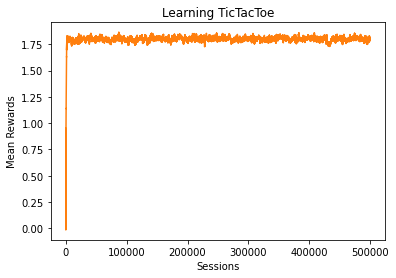

In [24]:
lastAction = -1

# Loop de treinamento do agente
with tqdm.trange( numEpisodes ) as episodes:  

    for episode in episodes:

        episodeReward = 0
        
        # Inicializa uma nova partida
        s      =  env.newGame()

        # Transforma o estado em tensor
        state  =  agent1.prepareStateTensor( s )

        # Determina quem começa a jogar
        player =  'X' if episode % 2 == 0 else 'O'

        jogadas = []

        tdJogadas = []

        playerO = 0

        # Numero de jogadas por partida
        for t in range(maxSteps):

            # Verifica se o jogador é o "X"
            if player == 'X':
                # A rede neural retorna a melhor ação para essa jogada
                sAction  =  agent1.selectAction( state, env.getOnlyValidAction() )

                # Obtem o valor da ação
                action  =  sAction.item()                
            else:
                # Agente pseudo aleatório
                # Seleciona uma ação randomica com opções válidas disponíveis no tabuleiro
                if t == 0 :
                    if lastAction == 8:
                        lastAction = 0
                    else:
                        lastAction += 1
                    action  =  lastAction
                else:
                    action  =  agent0.selectAction( env.getOnlyValidAction(), s )

            # Executa a ação no ambiente
            nextState, reward, done = env.step( action, player )
            tdJogadas.append( reward )
            s  =  nextState

            # Verifica se é o jogador "O", vamos guardar as ações dele
            if player == 'X':
                
                # Adiciona a recompensa
                episodeReward  +=  reward

                # Armazena a experiência do agente para treinamento
                jogadas.append([state, nextState, sAction, reward, done])
                #agent1.store(state, nextState, sAction, reward, done)           
            
            # Seta o estado
            state   =  agent1.prepareStateTensor( nextState )

            # Verifica se terminou
            if done:
                break

            # Troca o player para a próxima rodada do game
            player =  'X' if player == 'O' else 'O'
        
        games += env.render()+"\n"

        # Calcula o TD Lambda das recompensas
        tdJogadas  =  avaliaJogadas( tdJogadas )
        index      =  0 if episode % 2 == 0 else 1
        j          =  0
        for i in range(len(tdJogadas)):
            if i % 2 == index:
                _reward  =  tdJogadas[i]
                _state, _nextState, _sAction, r, _done  = jogadas[j]
                agent1.store(_state, _nextState, _sAction, _reward, _done)
                j += 1
        

        #for k in range(len(jogadas)):
        #    _state, _nextState, _sAction, _reward, _done  = jogadas[k]
        #    agent1.store(_state, _nextState, _sAction, _reward, _done)

        if episode > 0 and episode % config["trainEpisodesModule"] == 0:
            # Otimiza a rede neural
            agent1.optimize()

        if episode > 0 and episode % 50000 == 0:
            # Otimiza a rede neural
            agent1.saveModel( pwd+'/models', '{}_policy_model.pth'.format(trainId), '{}_target_model.pth'.format(trainId) )
            showScores( scoresReward, pwd+'/logs/{}.jpg'.format(trainId) )

            f = open( pwd+'/logs/game-{}.txt'.format(trainId), 'a' )
            f.write(games)
            f.close()
            games = ''

        # Insere a recompensa do episódio
        episodesReward.append( episodeReward )

        # Dados para gráfico de scores
        scoresReward.append( sum( episodesReward ) / (len( episodesReward ) + 1.) )

        # Calcula a média de recompensas
        runningReward  =  statistics.mean( episodesReward )    

        # Atualiza a contagem
        episodes.set_description(f'Episode {episode}')

        # Exibe os dados
        episodes.set_postfix(
            episode_reward="{:.3f}".format( episodeReward ),
            running_reward="{:.3f}".format( runningReward ))

# Save model
agent1.saveModel( pwd+'/models', '{}_policy_model.pth'.format(trainId), '{}_target_model.pth'.format(trainId) )
showScores( scoresReward, pwd+'/logs/{}.jpg'.format(trainId) )